# Chapter 6

## Question 11

Open-ended prediction of the per-capita crime rate on the `Boston` data set

In [1]:
import statsmodels.api as sm
import seaborn as sns
import sklearn.model_selection
import sklearn.linear_model
import sklearn.pipeline
import numpy as np
import itertools
import matplotlib.pyplot as plt
import sklearn.cross_decomposition

import warnings
warnings.filterwarnings("ignore", "Data with input dtype int64.* were all converted to float64 by StandardScaler")

In [2]:
boston = sm.datasets.get_rdataset("Boston", "MASS").data
boston.head()

crim    zn  indus  chas    nox     rm   age     dis  rad  tax  ptratio  \
0  0.00632  18.0   2.31     0  0.538  6.575  65.2  4.0900    1  296     15.3   
1  0.02731   0.0   7.07     0  0.469  6.421  78.9  4.9671    2  242     17.8   
2  0.02729   0.0   7.07     0  0.469  7.185  61.1  4.9671    2  242     17.8   
3  0.03237   0.0   2.18     0  0.458  6.998  45.8  6.0622    3  222     18.7   
4  0.06905   0.0   2.18     0  0.458  7.147  54.2  6.0622    3  222     18.7   

    black  lstat  medv  
0  396.90   4.98  24.0  
1  396.90   9.14  21.6  
2  392.83   4.03  34.7  
3  394.63   2.94  33.4  
4  396.90   5.33  36.2

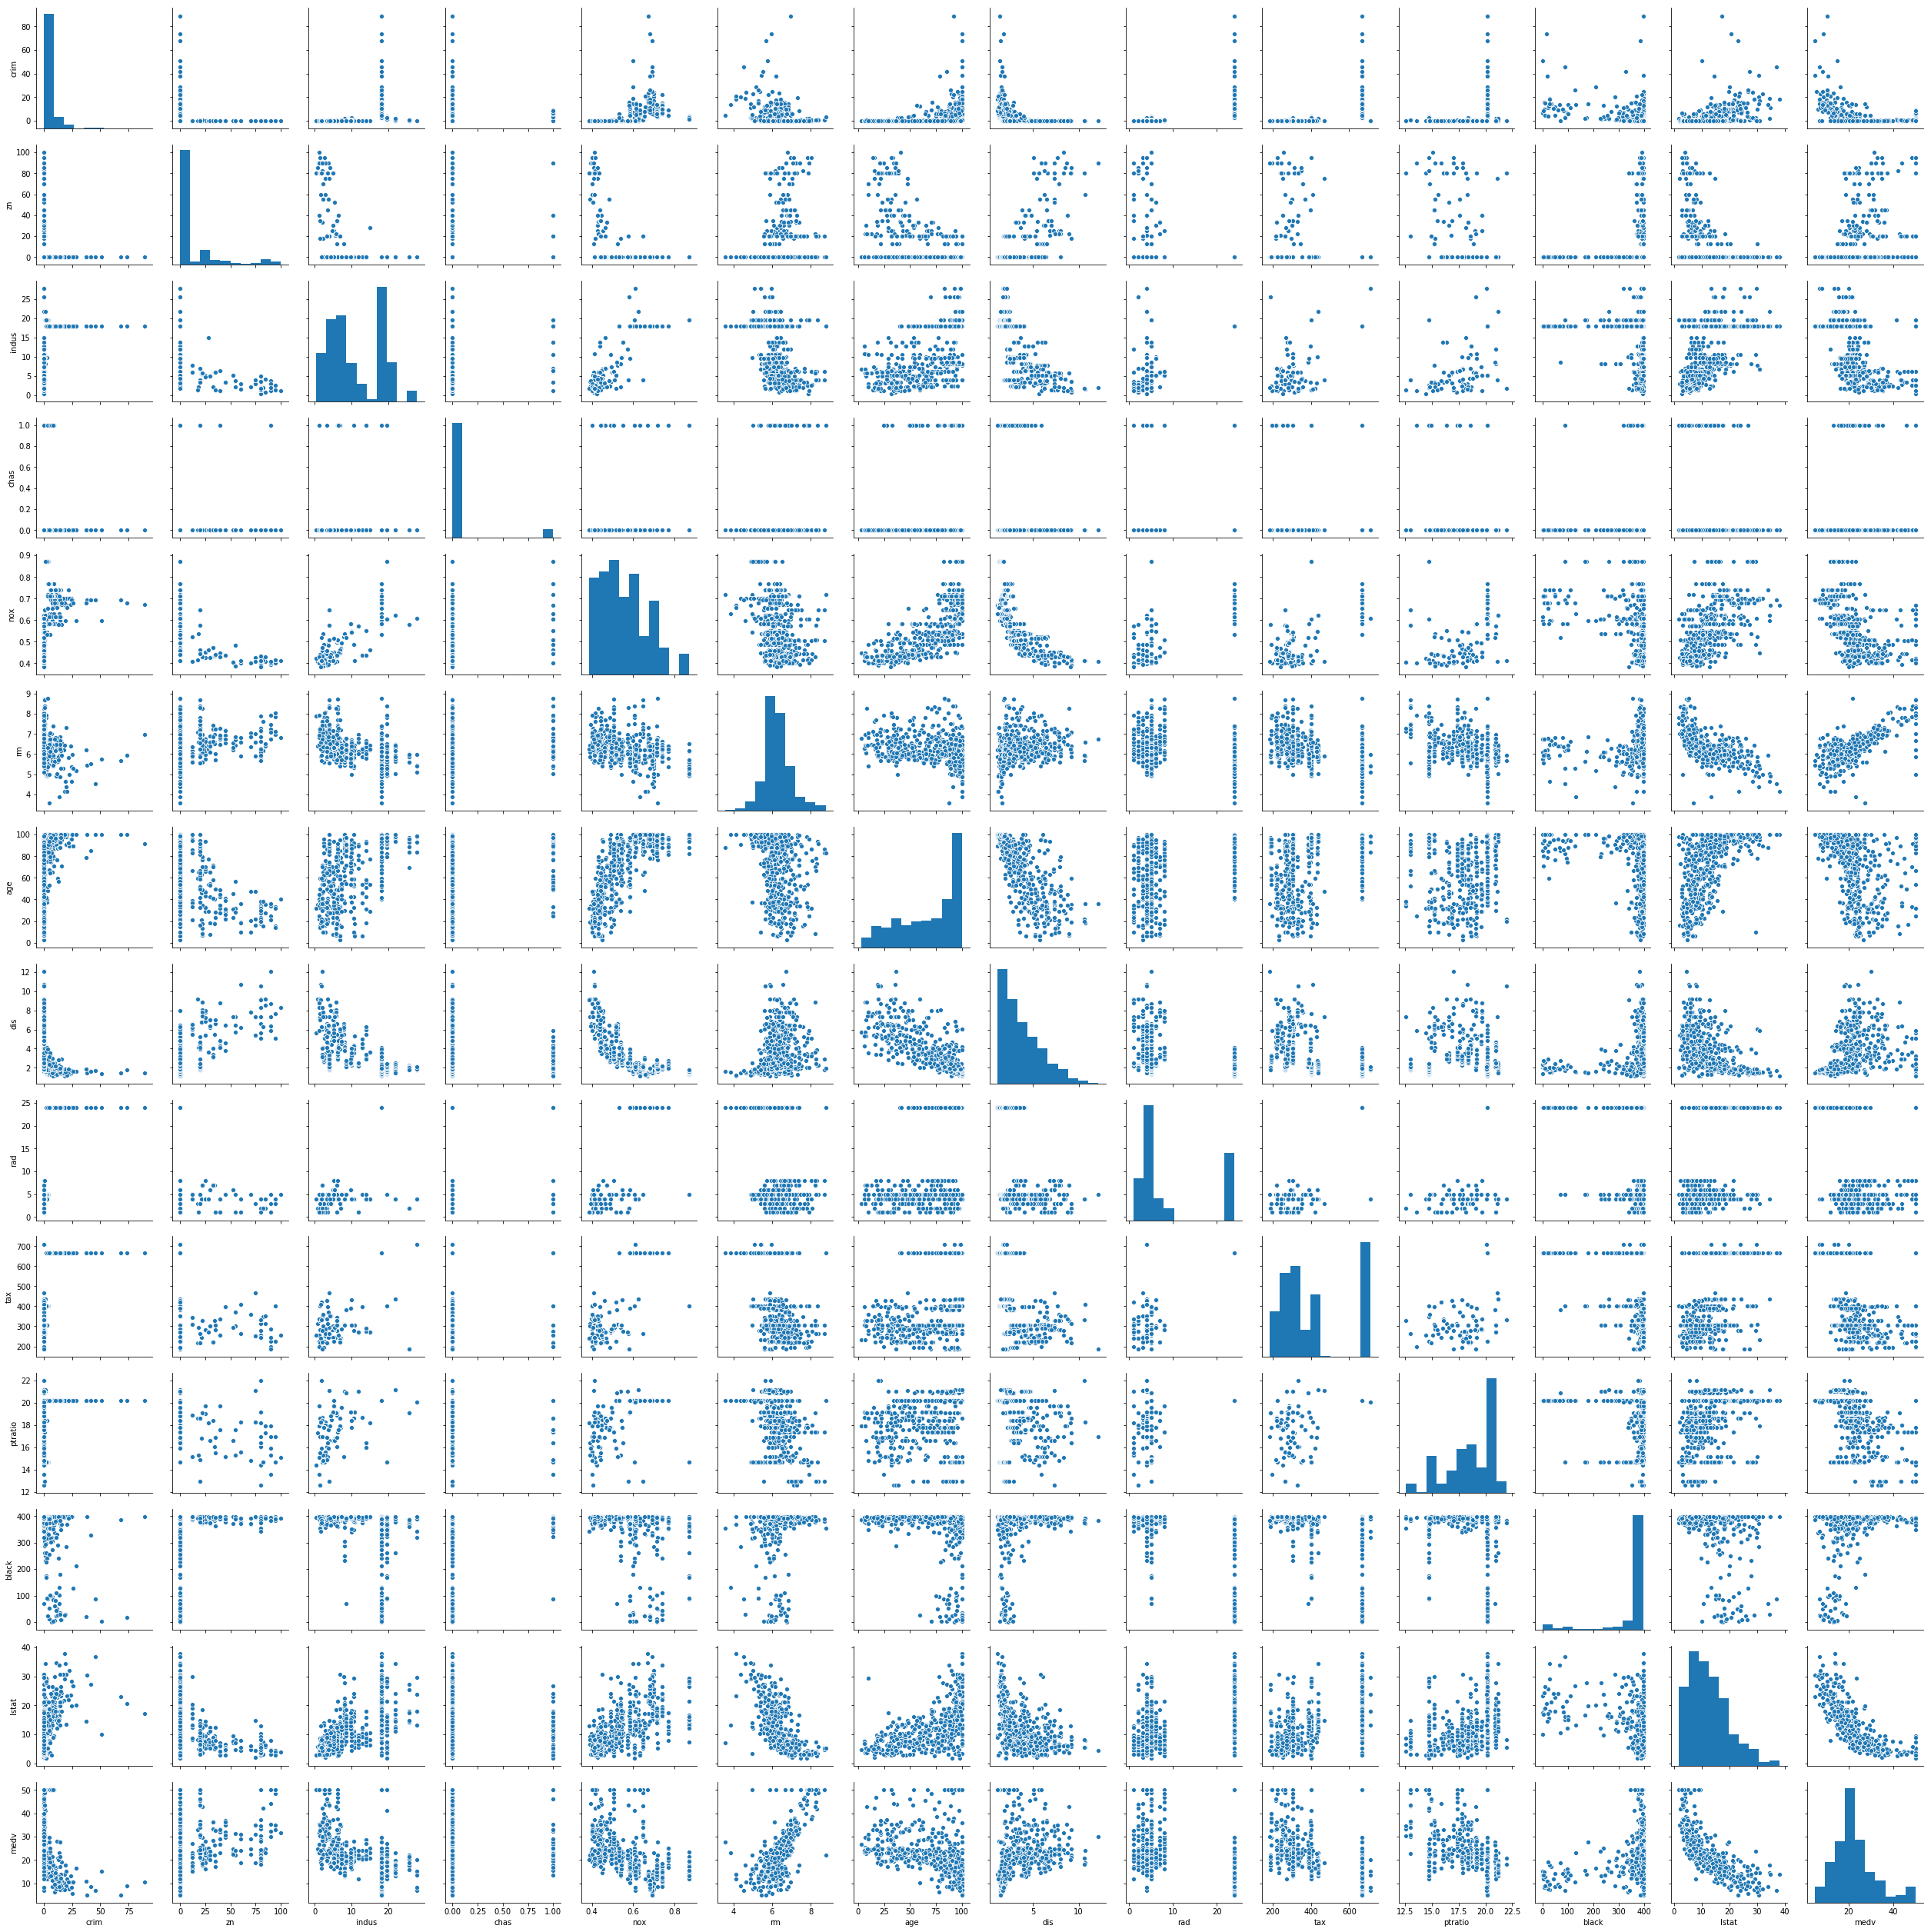

In [3]:
sns.pairplot(boston)

### (a) Try out the regression methods of chapter 6, e..g best-subset selection, the lasso, ridge regression, and PCR/PLS. Discuss.

In [4]:
X = boston.drop(columns=["crim"])
y = boston.crim


Start with the easiest possible model - ordinary least squares using all features.

In [5]:
least_squares = sklearn.linear_model.LinearRegression()

scores = sklearn.model_selection.cross_val_score(least_squares, X,y, scoring="neg_mean_squared_error", cv=5)
print(np.mean(scores))

-49.697493112805496


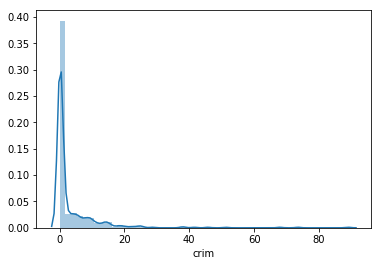

In [6]:
sns.distplot(y)

 An MSE of 49 isn't great on this data. Lets try:
 - best subset selection
 - lasso
 - ridge regression
 - pls

#### Best subset selection:

In [7]:
# Standardise each predictor:

def get_linear_reg_score(X,Y):
    """Given X and Y, fit a linear model and return the MSE"""
    scaler = sklearn.preprocessing.StandardScaler()
    regressor = sklearn.linear_model.LinearRegression()

    pipe = sklearn.pipeline.Pipeline(steps=[("scaling", scaler), ("linear regression", regressor)])

    scores = sklearn.model_selection.cross_val_score(pipe, X,y, scoring="neg_mean_squared_error", cv=5)
    return -np.mean(scores)

bestPredictors = []

p = len(X.columns)

for k in range(1,p+1):
    print(k)
    bestModelMSE = 1e9 
    bestColumns = None
    for subset in itertools.combinations(X.columns,k):
        mse = get_linear_reg_score(X[list(subset)],y)
        if mse < bestModelMSE:
            bestModelMSE = mse
            bestColumns = list(subset) 
    bestPredictors.append(bestColumns)
    

1
2
3
4
5
6
7
8
9
10
11
12
13


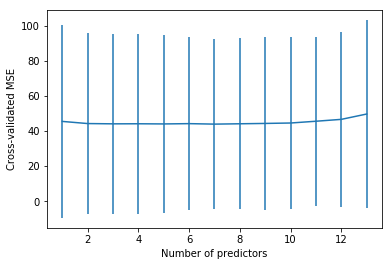

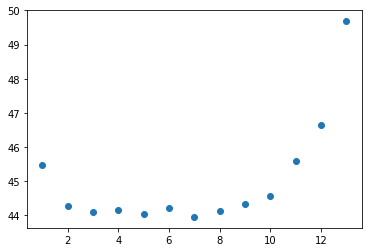

In [8]:

def get_linear_reg_score_and_error(X,Y):
    """Given X and Y, fit a linear model and return the MSE"""
    scaler = sklearn.preprocessing.StandardScaler()
    regressor = sklearn.linear_model.LinearRegression()

    pipe = sklearn.pipeline.Pipeline(steps=[("scaling", scaler), ("linear regression", regressor)])

    scores = sklearn.model_selection.cross_val_score(pipe, X,y, scoring="neg_mean_squared_error", cv=5)
    return -np.mean(scores), np.std(scores)

scores = [get_linear_reg_score_and_error(X[list(subset)],y)[0] for subset in bestPredictors]
errors = [get_linear_reg_score_and_error(X[list(subset)],y)[1] for subset in bestPredictors]
# plt.scatter(range(1,p+1), scores)
plt.errorbar(range(1,p+1), scores, yerr=errors)
plt.ylabel("Cross-validated MSE")
plt.xlabel("Number of predictors")
plt.show()
plt.scatter(range(1,p+1), scores)
plt.show()

In [9]:
print(bestPredictors[2])

['zn', 'rad', 'lstat']


The trend looks good, until we look at the error bars! And the difference is pretty marginal. It does suggest that `['zn', 'rad', 'lstat']` are the most useful predictors though

#### Lasso:

In [10]:
# Use the LassoCV
lasso_model = sklearn.linear_model.LassoLarsCV(cv=5, max_iter=1e6)
lasso_model.fit(X,y)


LassoLarsCV(copy_X=True, cv=5, eps=2.220446049250313e-16, fit_intercept=True,
      max_iter=1000000.0, max_n_alphas=1000, n_jobs=None, normalize=True,
      positive=False, precompute='auto', verbose=False)

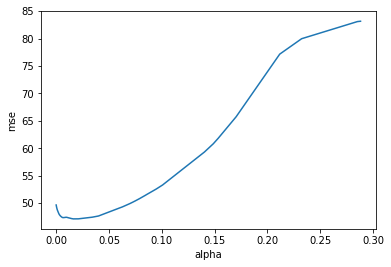

In [11]:
mse = list(map(np.mean,lasso_model.mse_path_))
alpha = lasso_model.cv_alphas_
plt.plot(alpha,mse)
plt.ylabel("mse")
plt.xlabel("alpha")
plt.show()

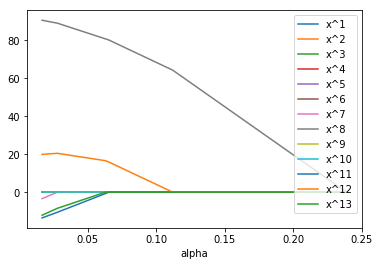

In [12]:
coefficients = lasso_model.coef_path_
for i,coefficient in enumerate(coefficients):
    plt.plot(lasso_model.alphas_, coefficient, label=f"x^{i+1}")
plt.xlabel("alpha")
plt.legend()

In [13]:
lasso_model.coef_


array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        , -0.07216378,  0.46253582,  0.        ,  0.        ,
       -0.0066009 ,  0.12398841, -0.05868302])

In [14]:
X.columns[np.where(lasso_model.coef_ != 0)]

Index(['dis', 'rad', 'black', 'lstat', 'medv'], dtype='object')

In [15]:
lasso_model

LassoLarsCV(copy_X=True, cv=5, eps=2.220446049250313e-16, fit_intercept=True,
      max_iter=1000000.0, max_n_alphas=1000, n_jobs=None, normalize=True,
      positive=False, precompute='auto', verbose=False)

Lasso with CV selects the `['dis', 'rad', 'black', 'lstat', 'medv']` columns, contrasting with the `['zn', 'rad', 'lstat']` chosen by best-subset

In [16]:
scores = sklearn.model_selection.cross_val_score(lasso_model, X,y, scoring="neg_mean_squared_error", cv=5)
print(-np.mean(scores))

50.613321807791294


#### Ridge regression

In [17]:
ridge = sklearn.linear_model.RidgeCV(alphas= np.linspace(0.001,10,num=1000))
scores = sklearn.model_selection.cross_val_score(ridge, X,y, scoring="neg_mean_squared_error", cv=5)
print(-np.mean(scores))

49.01553866506854


In [18]:
X.columns[np.where(ridge.fit(X,y).coef_ > 0.01)]

Index(['zn', 'rm', 'rad', 'lstat'], dtype='object')

#### PLS 


In [19]:
pls = sklearn.cross_decomposition.PLSRegression()

# pipe = sklearn.pipeline.Pipeline(steps=[("scaling", scaler), ("pca", pca), ("linear regression", regressor)])

p = len(X.columns)
params = {"n_components": list(range(1,p+1))}

search = sklearn.model_selection.GridSearchCV(pls, params, cv=5, return_train_score=True)
search.fit(X, y)

/home/will/.local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=PLSRegression(copy=True, max_iter=500, n_components=2, scale=True, tol=1e-06),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_components': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [20]:
best_pls = search.best_estimator_
print(search.best_params_)

{'n_components': 3}


In [21]:
scores = sklearn.model_selection.cross_val_score(best_pls, X,y, scoring="neg_mean_squared_error", cv=5)
print(-np.mean(scores))

48.53825373175748
